In [122]:
# load dataset
! pip install kaggle

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle (1).json"

In [5]:
!kaggle datasets download -d stealthtechnologies/traffic-time-series-dataset

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/traffic-time-series-dataset
License(s): apache-2.0
  0% 0.00/47.3k [00:00<?, ?B/s]
100% 47.3k/47.3k [00:00<00:00, 38.9MB/s]


In [6]:
with ZipFile("traffic-time-series-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("traffic_data")

In [7]:
data = pd.read_csv('/content/traffic_data/traffic_dataset_with_trend.csv')

In [143]:
# Import libraries
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, GRU

In [ ]:
# EDA

In [8]:
data.head()

,Timestamp,Weather,Events,Traffic Volume
0,2023-01-01 00:00:00,Cloudy,False,803.0
1,2023-01-01 01:00:00,Clear,False,861.0
2,2023-01-01 02:00:00,Clear,False,582.0
3,2023-01-01 03:00:00,Cloudy,False,236.0
4,2023-01-01 04:00:00,Cloudy,False,569.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       8736 non-null   object 
 1   Weather         8736 non-null   object 
 2   Events          8736 non-null   bool   
 3   Traffic Volume  8736 non-null   float64
dtypes: bool(1), float64(1), object(2)
memory usage: 213.4+ KB


In [10]:
data.isna().sum()

,0
Timestamp,0
Weather,0
Events,0
Traffic Volume,0


In [11]:
data.describe() # mean - 50

,Traffic Volume
count,8736.000000
mean,1281.395833
std,727.291462
min,118.000000
25%,893.000000
50%,1123.000000
75%,1415.000000
max,6465.000000


In [12]:
data['Weather'].unique()

array(['Cloudy', 'Clear', 'Rain', 'Snow'], dtype=object)

<Axes: xlabel='Weather', ylabel='Count'>

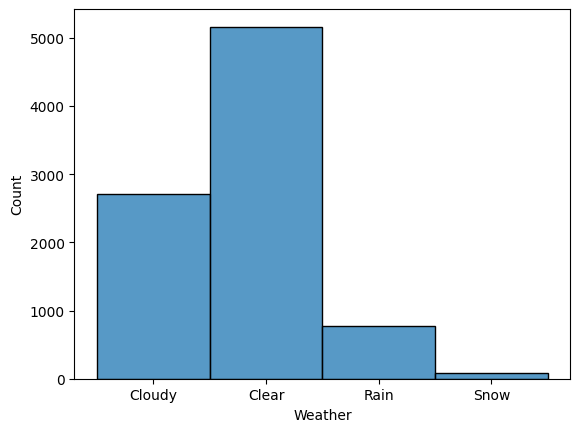

In [13]:
sns.histplot(data['Weather'])

In [14]:
data['Events'].unique()

array([False,  True])

<Axes: xlabel='Events', ylabel='Count'>

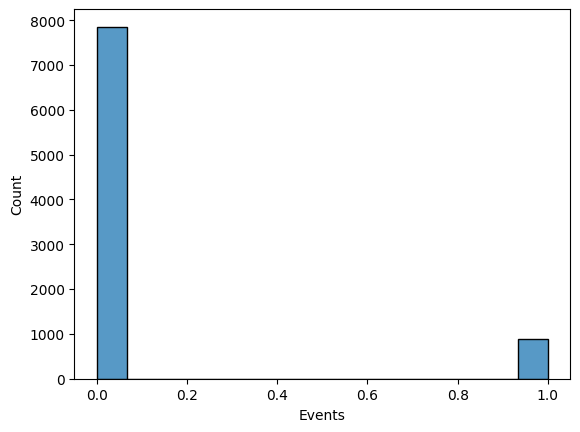

In [15]:
sns.histplot(data['Events'])

In [16]:
data.shape

(8736, 4)

In [17]:
data.duplicated().sum()

0

In [18]:
event_means = data.groupby('Events')['Traffic Volume'].mean()

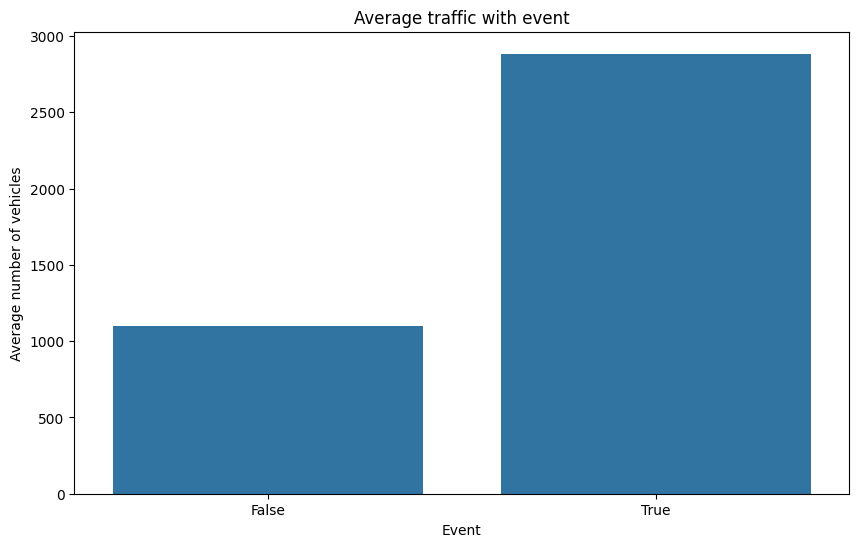

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=event_means.index, y=event_means.values)
plt.title('Average traffic with event')
plt.xlabel('Event')
plt.ylabel('Average number of vehicles')
plt.show()

In [20]:
# preprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [21]:
data.set_index('Timestamp', inplace=True)

In [22]:
data.drop('Weather', axis = 1, inplace = True)

In [24]:
data.drop('Events', axis = 1, inplace = True)

In [74]:
data

,Traffic Volume Scaled
Timestamp,
2023-01-01 00:00:00,-0.657815
2023-01-01 01:00:00,-0.578062
2023-01-01 02:00:00,-0.961700
2023-01-01 03:00:00,-1.437465
2023-01-01 04:00:00,-0.979575
...,...
2023-12-30 19:00:00,-0.224676
2023-12-30 20:00:00,0.549473
2023-12-30 21:00:00,-0.616564


In [26]:
scaler = StandardScaler()

In [27]:
data['Traffic Volume Scaled'] = scaler.fit_transform(data[['Traffic Volume']])

In [29]:
data.drop('Traffic Volume', axis = 1, inplace = True)

In [30]:
data

,Traffic Volume Scaled
Timestamp,
2023-01-01 00:00:00,-0.657815
2023-01-01 01:00:00,-0.578062
2023-01-01 02:00:00,-0.961700
2023-01-01 03:00:00,-1.437465
2023-01-01 04:00:00,-0.979575
...,...
2023-12-30 19:00:00,-0.224676
2023-12-30 20:00:00,0.549473
2023-12-30 21:00:00,-0.616564


In [31]:
data.describe()

,Traffic Volume Scaled
count,8.736000e+03
mean,1.154957e-16
std,1.000057e+00
min,-1.599720e+00
25%,-5.340611e-01
50%,-2.178011e-01
75%,1.837115e-01
max,7.127680e+00


In [ ]:
# outlieaes

In [32]:
Q1 = data['Traffic Volume Scaled'].quantile(0.25)
Q3 = data['Traffic Volume Scaled'].quantile(0.75)
IQR = Q3 - Q1

In [33]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [35]:
filtered_data = data[(data['Traffic Volume Scaled'] >= lower_bound) & (data['Traffic Volume Scaled'] <= upper_bound)]

In [75]:
filtered_data

,Traffic Volume Scaled
Timestamp,
2023-01-01 00:00:00,-0.657815
2023-01-01 01:00:00,-0.578062
2023-01-01 02:00:00,-0.961700
2023-01-01 03:00:00,-1.437465
2023-01-01 04:00:00,-0.979575
...,...
2023-12-30 19:00:00,-0.224676
2023-12-30 20:00:00,0.549473
2023-12-30 21:00:00,-0.616564


In [127]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [128]:
look_back = 1

trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)


In [223]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [224]:
model = Sequential()
model.add(GRU(32, input_shape=(1, look_back), return_sequences=True))
#model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True))

model.add(GRU(256, return_sequences=True))

#model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(1))

In [225]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [226]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                         │ (None, 1, 32)               │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_29 (GRU)                         │ (None, 1, 256)              │         222,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_30 (GRU)                         │ (None, 1, 256)              │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_31 (GRU)                         │ (None, 64)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,721 (2.60 MB)

 Trainable params: 682,721 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [227]:
history = model.fit(trainX,trainY, epochs=4, batch_size=32, validation_split=0.2)

Epoch 1/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2359 - val_loss: 0.2179
Epoch 2/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2251 - val_loss: 0.2179
Epoch 3/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2233 - val_loss: 0.2178
Epoch 4/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2219 - val_loss: 0.2180


In [228]:
loss = model.evaluate(testX,testY)
print(f'Test Loss: {loss}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993
Test Loss: 0.20303381979465485


In [229]:
y_pred = model.predict(testX)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [230]:
testX

array([[[-0.42818275]],

       [[-0.79669435]],

       [[-0.07892176]],

       ...,

       [[ 0.64985118]],

       [[-0.54231134]],

       [[-0.27967807]]])

In [231]:
y_test.shape

(1632,)

In [232]:
y_pred.shape

(1631, 1)

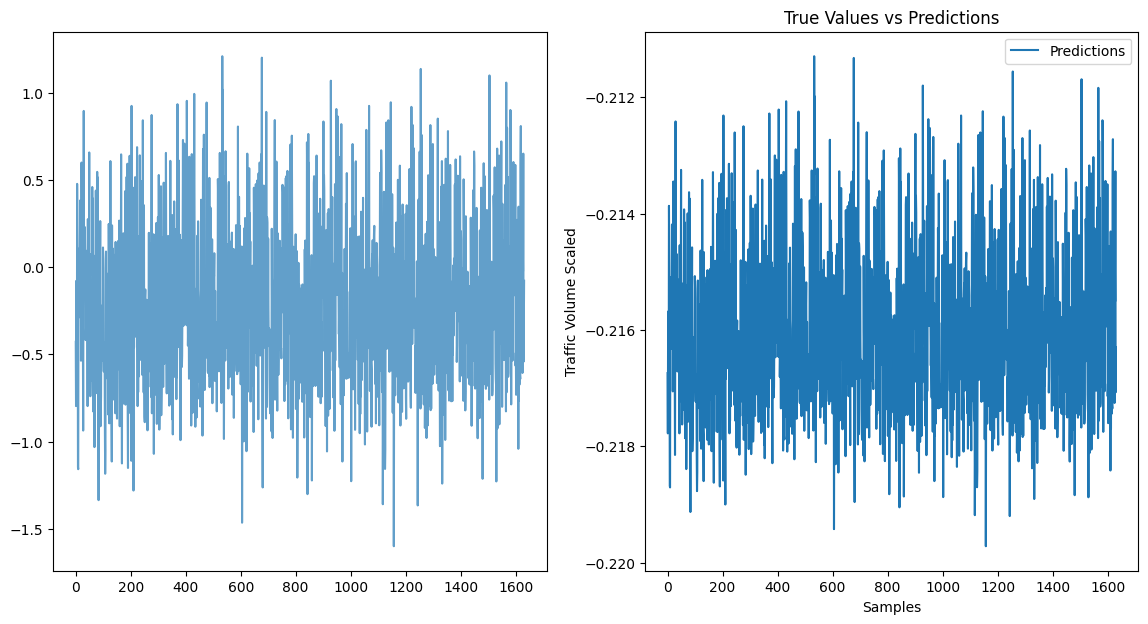

In [233]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='True Values', alpha=0.7)
plt.subplot(1, 2, 2)

plt.plot(y_pred, label='Predictions')
plt.title('True Values vs Predictions')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume Scaled')
plt.legend()
plt.show()

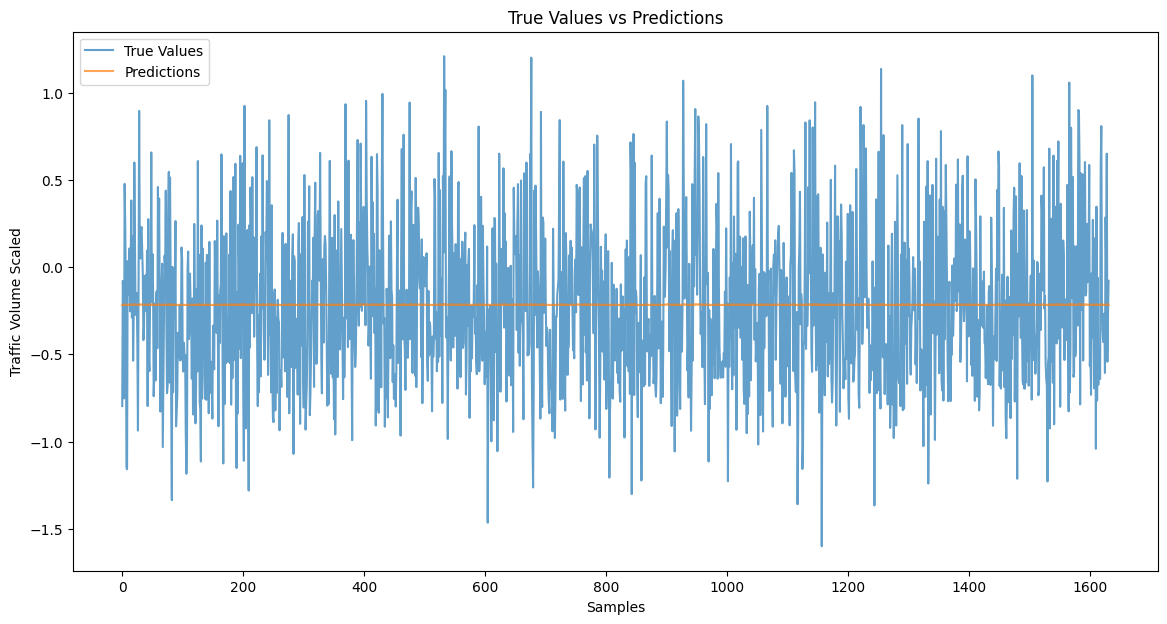

In [234]:
plt.figure(figsize=(14, 7))
plt.plot(testY, label='True Values', alpha=0.7)
plt.plot(y_pred, label='Predictions', alpha=0.7)
plt.title('True Values vs Predictions')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume Scaled')
plt.legend()
plt.show()

In [155]:
loss = history.history['loss']
val_loss = history.history['val_loss']

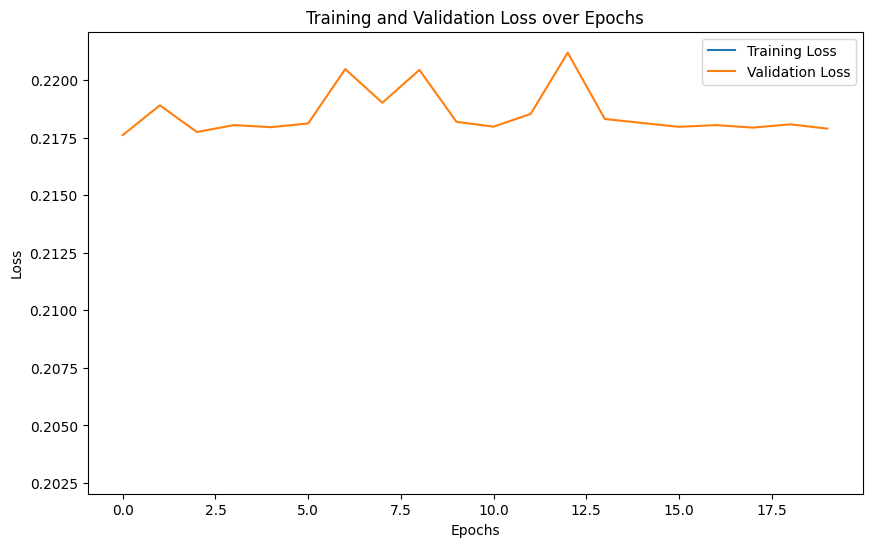

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()